In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras import models
from keras import layers
from keras.utils import np_utils

C:\Users\admin\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

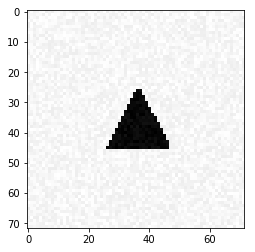

In [3]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(72,72), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(72,72), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(72,72), cmap='gray')

In [7]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((72,72))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)
    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

In [8]:
[x_train, y_train] = generate_dataset_classification(300, 20)

Creating data:


In [9]:
from keras.utils.np_utils import to_categorical
categorical_labels = to_categorical(y_train, num_classes=None)

In [125]:
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.optimizers import SGD, Adam

In [11]:
BATCH_SIZE = 32
INIT_LR = 0.0001
EPOCHS = 100
input_shape=(x_train.shape[1],)

In [12]:
model = Sequential()
# # Input - Layer
model.add(Dense(68, input_shape=input_shape, activation='sigmoid'))
# Output- Layer
model.add(Dense(3, activation='softmax'))

In [13]:
model.predict(x_train)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 68)                352580    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 207       
Total params: 352,787
Trainable params: 352,787
Non-trainable params: 0
_________________________________________________________________


In [14]:
opt_gd = SGD(lr=INIT_LR, decay=1e-6, momentum=0.9, nesterov=True)
opt_adam = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [15]:
model.compile(loss="categorical_crossentropy", optimizer=opt_adam, metrics=["accuracy"])
# model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

In [16]:
results = model.fit(
 x_train, categorical_labels,
 epochs= EPOCHS,
 batch_size = BATCH_SIZE
)

Epoch 1/100
300/300 [==============================] - 0s - loss: 1.0856 - acc: 0.4133     
Epoch 2/100
300/300 [==============================] - 0s - loss: 0.9121 - acc: 0.7500     
Epoch 3/100
300/300 [==============================] - 0s - loss: 0.8041 - acc: 0.7000     
Epoch 4/100
300/300 [==============================] - 0s - loss: 0.7224 - acc: 0.7733     
Epoch 5/100
300/300 [==============================] - 0s - loss: 0.6506 - acc: 0.8667     
Epoch 6/100
300/300 [==============================] - 0s - loss: 0.5964 - acc: 0.8800     
Epoch 7/100
300/300 [==============================] - 0s - loss: 0.5459 - acc: 0.8867     
Epoch 8/100
300/300 [==============================] - 0s - loss: 0.5100 - acc: 0.9200     
Epoch 9/100
300/300 [==============================] - 0s - loss: 0.4755 - acc: 0.9267     
Epoch 10/100
300/300 [==============================] - 0s - loss: 0.4458 - acc: 0.9233     
Epoch 11/100
300/300 [==============================] - 0s - loss: 0.4295 - acc

300/300 [==============================] - 0s - loss: 0.0575 - acc: 1.0000     
Epoch 89/100
300/300 [==============================] - 0s - loss: 0.0554 - acc: 1.0000     
Epoch 90/100
300/300 [==============================] - 0s - loss: 0.0553 - acc: 1.0000     
Epoch 91/100
300/300 [==============================] - 0s - loss: 0.0542 - acc: 1.0000     
Epoch 92/100
300/300 [==============================] - 0s - loss: 0.0522 - acc: 1.0000     
Epoch 93/100
300/300 [==============================] - 0s - loss: 0.0528 - acc: 1.0000     
Epoch 94/100
300/300 [==============================] - 0s - loss: 0.0512 - acc: 1.0000     
Epoch 95/100
300/300 [==============================] - 0s - loss: 0.0510 - acc: 1.0000     
Epoch 96/100
300/300 [==============================] - 0s - loss: 0.0508 - acc: 1.0000     
Epoch 97/100
300/300 [==============================] - 0s - loss: 0.0500 - acc: 1.0000     
Epoch 98/100
300/300 [==============================] - 0s - loss: 0.0481 - acc: 1.

In [17]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[1.2680404e-03, 9.9815708e-01, 5.7482877e-04]], dtype=float32)

In [18]:
list_weights = model.get_weights()

In [19]:
weights_classifier = list_weights[0]
from PIL import Image

In [20]:
print(weights_classifier.shape, x_train.shape)
a = weights_classifier[:,0]
print(a)

(5184, 68) (300, 5184)
[ 0.01100917  0.00697384 -0.02963229 ... -0.01688506 -0.01770202
  0.00185934]


In [21]:
img_as_np = a.reshape(72,72)
img = Image.fromarray(img_as_np.astype('uint8'))
img.show()

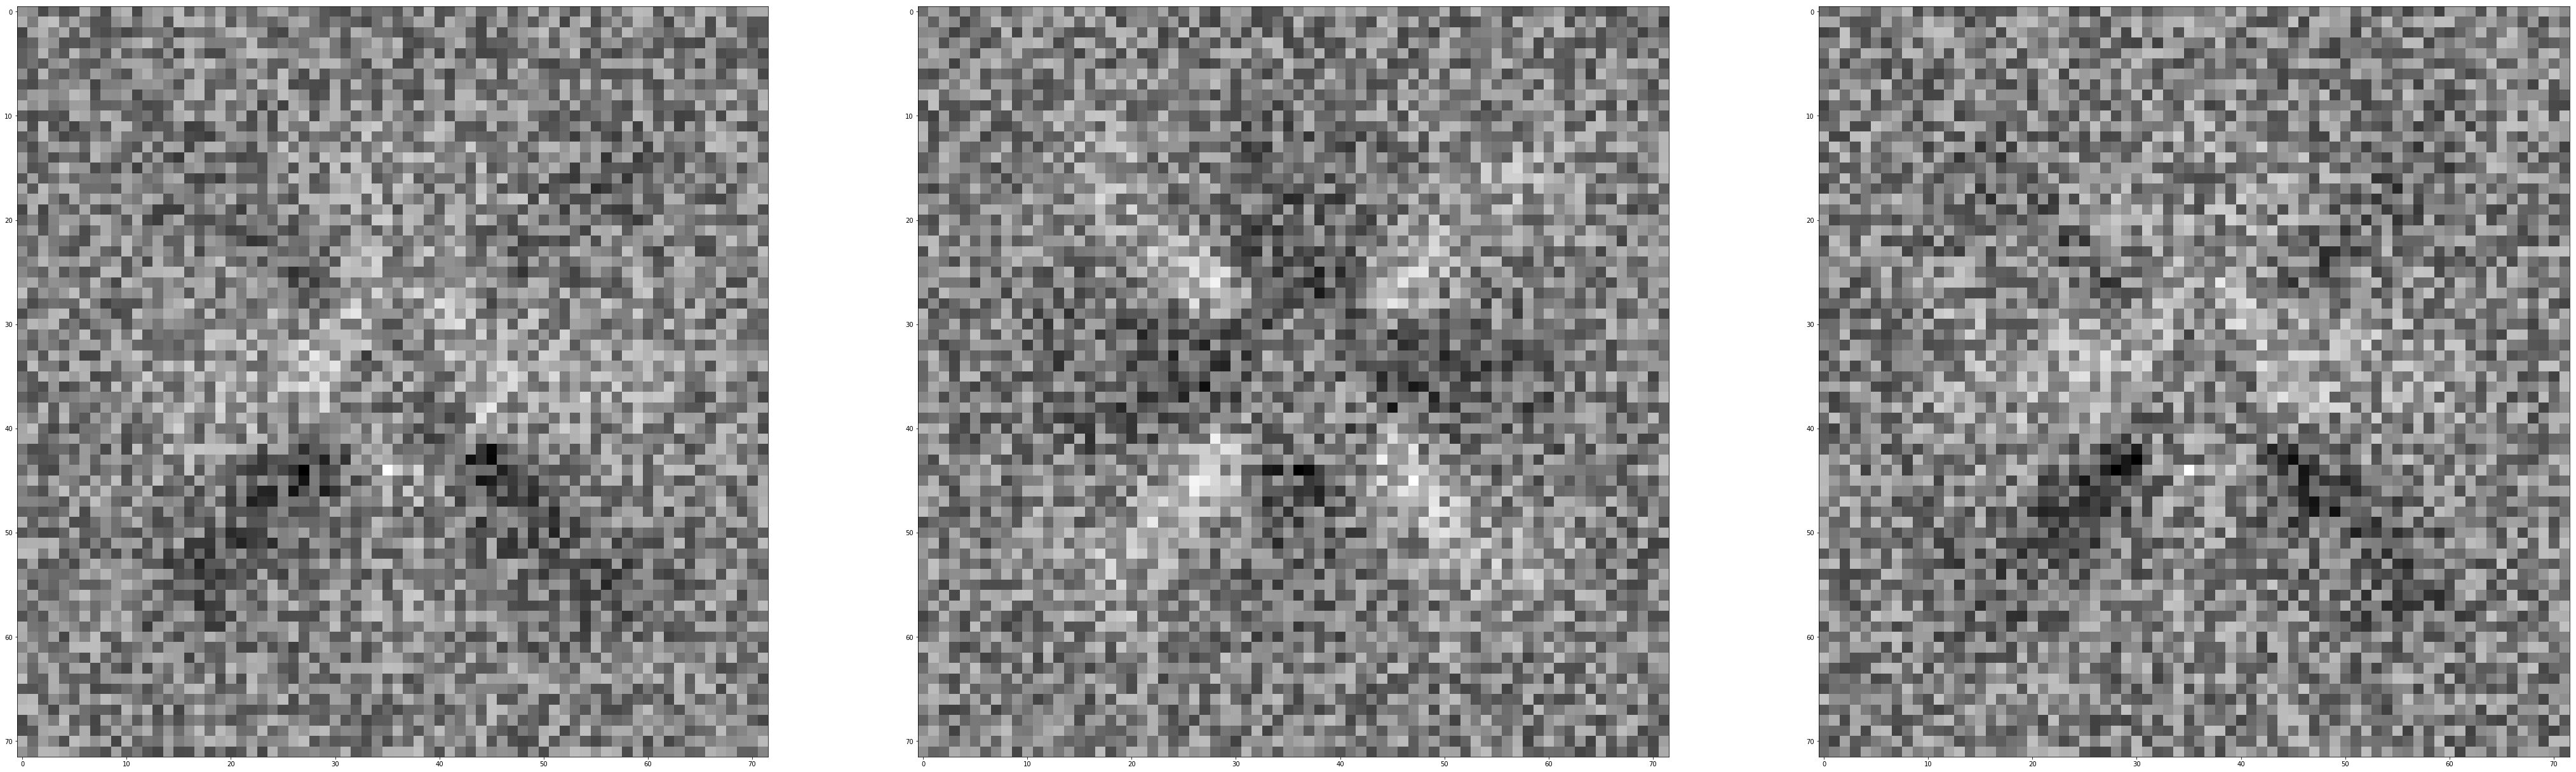

In [22]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(72, 72))
ax = (ax1, ax2, ax3)

for i, a in enumerate(ax):
    im = weights_classifier[:,i]
    a.imshow(im.reshape(72,72), cmap='gray')

plt.show()

In [23]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)

Creating data:


In [24]:
Y_train = to_categorical(Y_train, num_classes=None)
results = model.fit(
 X_train, Y_train,
 epochs= EPOCHS,
 batch_size = BATCH_SIZE
)

Epoch 1/100
300/300 [==============================] - 0s - loss: 1.8142 - acc: 0.3700     
Epoch 2/100
300/300 [==============================] - 0s - loss: 1.1778 - acc: 0.3767     
Epoch 3/100
300/300 [==============================] - 0s - loss: 1.1026 - acc: 0.3533     
Epoch 4/100
300/300 [==============================] - 0s - loss: 1.0843 - acc: 0.3833     
Epoch 5/100
300/300 [==============================] - 0s - loss: 1.0717 - acc: 0.4200     
Epoch 6/100
300/300 [==============================] - 0s - loss: 1.0618 - acc: 0.4167     
Epoch 7/100
300/300 [==============================] - 0s - loss: 1.0552 - acc: 0.4200     
Epoch 8/100
300/300 [==============================] - 0s - loss: 1.0521 - acc: 0.4500     
Epoch 9/100
300/300 [==============================] - 0s - loss: 1.0381 - acc: 0.4467     
Epoch 10/100
300/300 [==============================] - 0s - loss: 1.0345 - acc: 0.4567     
Epoch 11/100
300/300 [==============================] - 0s - loss: 1.0293 - acc

300/300 [==============================] - 0s - loss: 0.7328 - acc: 0.7200     
Epoch 89/100
300/300 [==============================] - 0s - loss: 0.7270 - acc: 0.7167     
Epoch 90/100
300/300 [==============================] - 0s - loss: 0.7315 - acc: 0.7200     
Epoch 91/100
300/300 [==============================] - 0s - loss: 0.7254 - acc: 0.7167     
Epoch 92/100
300/300 [==============================] - 0s - loss: 0.7229 - acc: 0.7500     
Epoch 93/100
300/300 [==============================] - 0s - loss: 0.7201 - acc: 0.7000     
Epoch 94/100
300/300 [==============================] - 0s - loss: 0.7163 - acc: 0.7333     
Epoch 95/100
300/300 [==============================] - 0s - loss: 0.7154 - acc: 0.7500     
Epoch 96/100
300/300 [==============================] - 0s - loss: 0.7162 - acc: 0.7267     
Epoch 97/100
300/300 [==============================] - 0s - loss: 0.7125 - acc: 0.7267     
Epoch 98/100
300/300 [==============================] - 0s - loss: 0.7115 - acc: 0.

In [25]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:


In [26]:
model.evaluate(X_test, Y_test)

 32/300 [==>...........................] - ETA: 0s

[0.802640655040741, 0.573333334128062]

In [27]:
print(Y_train.shape)

(300, 3)


In [28]:
conv_model = Sequential()
conv_model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=(72, 72, 1)))
conv_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
conv_model.add(Flatten())
conv_model.add(Dense(3, activation='softmax'))

In [29]:
conv_model.compile(loss="categorical_crossentropy", optimizer=opt_adam, metrics=["accuracy"])

In [30]:
results = conv_model.fit(
 X_train.reshape(-1,72,72,1), Y_train,
 epochs= EPOCHS,
 batch_size = BATCH_SIZE
)

Epoch 1/100
300/300 [==============================] - 1s - loss: 1.1032 - acc: 0.4000     
Epoch 2/100
300/300 [==============================] - 0s - loss: 0.9520 - acc: 0.6600     
Epoch 3/100
300/300 [==============================] - 0s - loss: 0.8367 - acc: 0.7600     
Epoch 4/100
300/300 [==============================] - 0s - loss: 0.7867 - acc: 0.6700     
Epoch 5/100
300/300 [==============================] - 0s - loss: 0.7383 - acc: 0.6500     
Epoch 6/100
300/300 [==============================] - 0s - loss: 0.6608 - acc: 0.8700     
Epoch 7/100
300/300 [==============================] - 1s - loss: 0.6310 - acc: 0.8600     
Epoch 8/100
300/300 [==============================] - 0s - loss: 0.6279 - acc: 0.7667     - ETA: 0s - loss: 0.6262 - acc: 
Epoch 9/100
300/300 [==============================] - 0s - loss: 0.5951 - acc: 0.7867     
Epoch 10/100
300/300 [==============================] - 0s - loss: 0.5688 - acc: 0.8133     
Epoch 11/100
300/300 [=========================

300/300 [==============================] - 0s - loss: 0.1595 - acc: 0.9933     
Epoch 88/100
300/300 [==============================] - 0s - loss: 0.1566 - acc: 0.9933     
Epoch 89/100
300/300 [==============================] - 0s - loss: 0.1613 - acc: 0.9900     
Epoch 90/100
300/300 [==============================] - 1s - loss: 0.1497 - acc: 0.9900     
Epoch 91/100
300/300 [==============================] - 0s - loss: 0.1479 - acc: 0.9933     
Epoch 92/100
300/300 [==============================] - 1s - loss: 0.1472 - acc: 0.9900     
Epoch 93/100
300/300 [==============================] - 0s - loss: 0.1441 - acc: 0.9967     
Epoch 94/100
300/300 [==============================] - 0s - loss: 0.1458 - acc: 0.9900     
Epoch 95/100
300/300 [==============================] - 0s - loss: 0.1474 - acc: 0.9933     
Epoch 96/100
300/300 [==============================] - 0s - loss: 0.1430 - acc: 0.9933     
Epoch 97/100
300/300 [==============================] - 1s - loss: 0.1410 - acc: 0.

In [31]:
print(Y_train.shape)

(300, 3)


In [32]:
conv_model.evaluate(X_test.reshape(-1,72,72,1), Y_test)

300/300 [==============================] - 0s     


[0.6452560448646545, 0.7566666666666667]

Creating data:


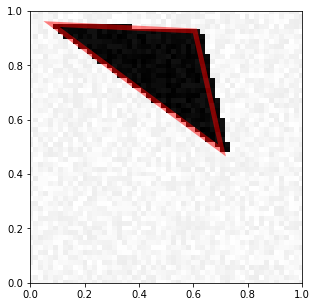

In [66]:
[X_train_reg, Y_train_reg] = generate_dataset_regression(300, 20)
visualize_prediction(X_train_reg[0], Y_train_reg[0])

In [210]:
print(X_train_reg[0], Y_train_reg[0])
print(X_train_reg.shape)

[0.99256407 0.99802415 0.97674939 ... 0.9382812  0.94889939 0.99140601] [0.60607948 0.92651435 0.07861791 0.9519063  0.70579627 0.4867485 ]
(300, 5184)


In [213]:
BATCH_SIZE = 32
INIT_LR = 0.0001
EPOCHS = 500
input_shape=(X_train_reg.shape[1],)
print(input_shape)

(5184,)


In [214]:
model_reg = Sequential()
# # Input - Layer
model_reg.add(Dense(256, input_shape=input_shape, activation='sigmoid'))
# Output- Layer
model_reg.add(Dense(6, activation='softmax'))

In [215]:
opt_adam = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model_reg.compile(loss="mean_squared_error", optimizer=opt_adam)
Y_train_reg_normalized = Y_train_reg/np.sum(Y_train_reg,axis=1)[:,None]

In [216]:
results = model_reg.fit(
 X_train_reg, Y_train_reg_normalized,
 epochs= EPOCHS,
 batch_size = BATCH_SIZE
)

Epoch 1/500
300/300 [==============================] - 0s - loss: 0.0125     
Epoch 2/500
300/300 [==============================] - 0s - loss: 0.0104     
Epoch 3/500
300/300 [==============================] - 0s - loss: 0.0098     
Epoch 4/500
300/300 [==============================] - 0s - loss: 0.0090     
Epoch 5/500
300/300 [==============================] - 0s - loss: 0.0084     - ETA: 0s - loss: 0.008
Epoch 6/500
300/300 [==============================] - 0s - loss: 0.0083     
Epoch 7/500
300/300 [==============================] - 0s - loss: 0.0084     
Epoch 8/500
300/300 [==============================] - 0s - loss: 0.0085     
Epoch 9/500
300/300 [==============================] - 0s - loss: 0.0082     
Epoch 10/500
300/300 [==============================] - 0s - loss: 0.0080     
Epoch 11/500
300/300 [==============================] - 0s - loss: 0.0081     
Epoch 12/500
300/300 [==============================] - 0s - loss: 0.0080     
Epoch 13/500
300/300 [================

300/300 [==============================] - 0s - loss: 0.0055     
Epoch 105/500
300/300 [==============================] - 0s - loss: 0.0052     
Epoch 106/500
300/300 [==============================] - 0s - loss: 0.0052     
Epoch 107/500
300/300 [==============================] - 0s - loss: 0.0053     
Epoch 108/500
300/300 [==============================] - 0s - loss: 0.0050     
Epoch 109/500
300/300 [==============================] - 0s - loss: 0.0052     
Epoch 110/500
300/300 [==============================] - 0s - loss: 0.0053     
Epoch 111/500
300/300 [==============================] - 0s - loss: 0.0052     
Epoch 112/500
300/300 [==============================] - 0s - loss: 0.0052     
Epoch 113/500
300/300 [==============================] - 0s - loss: 0.0050     
Epoch 114/500
300/300 [==============================] - 0s - loss: 0.0045     
Epoch 115/500
300/300 [==============================] - 0s - loss: 0.0048     
Epoch 116/500
300/300 [==============================]

300/300 [==============================] - 0s - loss: 0.0031     
Epoch 206/500
300/300 [==============================] - 0s - loss: 0.0032     
Epoch 207/500
300/300 [==============================] - 0s - loss: 0.0032     
Epoch 208/500
300/300 [==============================] - 0s - loss: 0.0031     
Epoch 209/500
300/300 [==============================] - 0s - loss: 0.0031     
Epoch 210/500
300/300 [==============================] - 0s - loss: 0.0028     
Epoch 211/500
300/300 [==============================] - 0s - loss: 0.0028     
Epoch 212/500
300/300 [==============================] - 0s - loss: 0.0028     
Epoch 213/500
300/300 [==============================] - 0s - loss: 0.0028     
Epoch 214/500
300/300 [==============================] - 0s - loss: 0.0030     
Epoch 215/500
300/300 [==============================] - 0s - loss: 0.0030     
Epoch 216/500
300/300 [==============================] - 0s - loss: 0.0029     
Epoch 217/500
300/300 [==============================]

300/300 [==============================] - 0s - loss: 0.0020     
Epoch 308/500
300/300 [==============================] - 0s - loss: 0.0021     
Epoch 309/500
300/300 [==============================] - 0s - loss: 0.0025     
Epoch 310/500
300/300 [==============================] - 0s - loss: 0.0024     
Epoch 311/500
300/300 [==============================] - 0s - loss: 0.0022     
Epoch 312/500
300/300 [==============================] - 0s - loss: 0.0021     
Epoch 313/500
300/300 [==============================] - 0s - loss: 0.0022     
Epoch 314/500
300/300 [==============================] - 0s - loss: 0.0020     
Epoch 315/500
300/300 [==============================] - 0s - loss: 0.0022     
Epoch 316/500
300/300 [==============================] - 0s - loss: 0.0021     
Epoch 317/500
300/300 [==============================] - 0s - loss: 0.0024     
Epoch 318/500
300/300 [==============================] - 0s - loss: 0.0022     
Epoch 319/500
300/300 [==============================]

300/300 [==============================] - 0s - loss: 0.0016     
Epoch 410/500
300/300 [==============================] - 0s - loss: 0.0015     
Epoch 411/500
300/300 [==============================] - 0s - loss: 0.0014     
Epoch 412/500
300/300 [==============================] - 0s - loss: 0.0014     
Epoch 413/500
300/300 [==============================] - 0s - loss: 0.0014     
Epoch 414/500
300/300 [==============================] - 0s - loss: 0.0014     
Epoch 415/500
300/300 [==============================] - 0s - loss: 0.0013     
Epoch 416/500
300/300 [==============================] - 0s - loss: 0.0015     
Epoch 417/500
300/300 [==============================] - 0s - loss: 0.0014     
Epoch 418/500
300/300 [==============================] - 0s - loss: 0.0015     
Epoch 419/500
300/300 [==============================] - 0s - loss: 0.0014     
Epoch 420/500
300/300 [==============================] - 0s - loss: 0.0014     
Epoch 421/500
300/300 [==============================]

In [217]:
Y_train_reg_pred = model_reg.predict(X_train_reg)
Y_train_cheat = Y_train_reg_pred * np.sum(Y_train_reg,axis=1)[:,None]

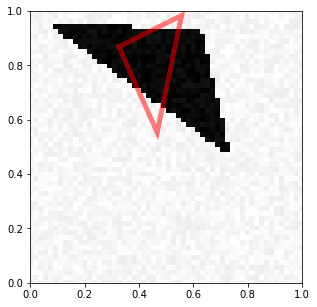

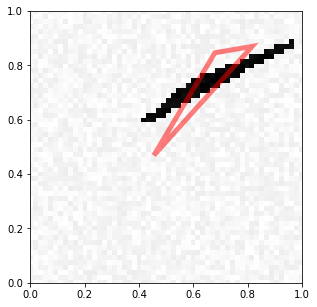

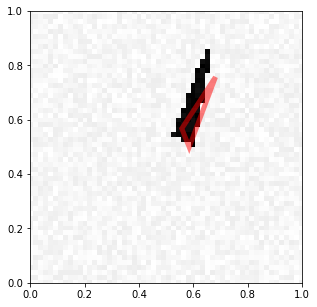

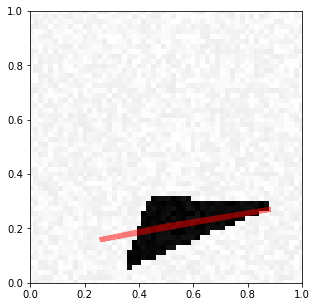

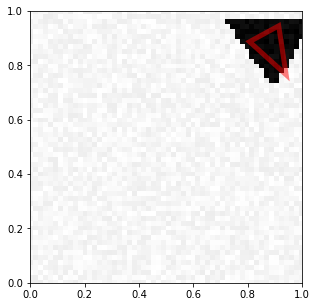

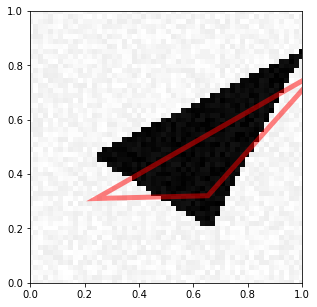

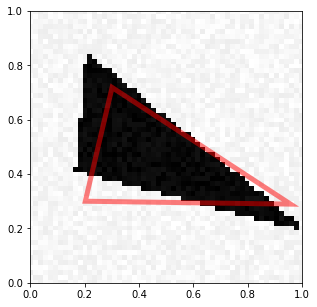

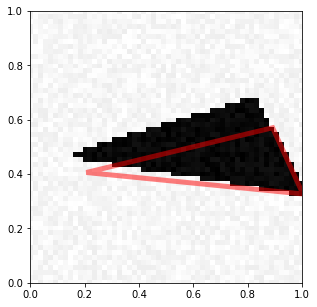

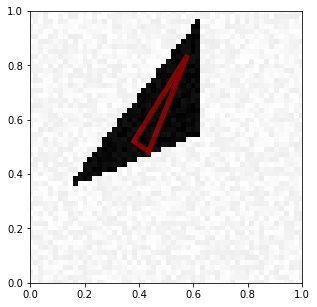

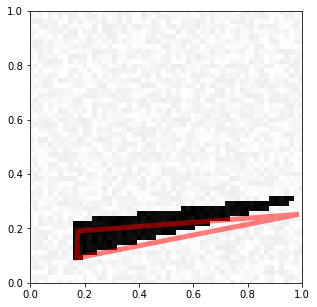

In [218]:
for i in range(10):
    visualize_prediction(X_train_reg[i], Y_train_cheat[i])

In [73]:
print(Y_train_reg[0], Y_train_reg_normalized[0], sum(Y_train_reg_normalized[0]))

[0.60607948 0.92651435 0.07861791 0.9519063  0.70579627 0.4867485 ] [0.1613775  0.24669796 0.02093317 0.25345894 0.18792855 0.12960389] 1.0


In [ ]:
np.random.seed(42)
noise = np.random.normal(loc=0.5, scale=0.5, size=X_train_reg.shape)
x_train_noisy = X_train_reg + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=X_train_reg.shape)
x_test_noisy = x_test + noise

In [ ]:
input_img = Input(shape=(72, 72, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

history = autoencoder.fit(X_noisy, X_noise_free,
    epochs=20,                
    batch_size=32,
    shuffle=True,
    validation_data=(X_test_noisy, X_test_noise_free),
    verbose=0
)

In [ ]:
def generate_a_rectangle_pairs(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise=0), generate_a_drawing(figsize, U, V, noise)

def generate_a_disk_pairs(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise=0), generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle_pairs(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    noise_free, noisy = generate_a_drawing(figsize, U, V, noise=0), generate_a_drawing(figsize, U, V, noise)
    return noise_free, noisy

def generate_dataset_classification_pairs(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    noise_free = np.zeros([nb_samples,im_size])
    noisy = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            noise_free[i], noisy[i] = generate_a_rectangle_pairs(noise, free_location)
        elif category == 1: 
            noise_free[i], noisy[i] = generate_a_disk_pairs(noise, free_location)
        else:
            noise_free[i], noisy[i] = generate_a_triangle_pairs(noise, free_location)
        Y[i] = category
    noise_free = noise_free / 255
    noisy = (noisy + noise) / (255 + 2 * noise)
#     noisy = noisy / 255
    return [noise_free, noisy, Y]

In [ ]:
X_noise_free, X_noisy, Y = generate_dataset_classification_pairs(
    nb_samples=300, noise=50, free_location=True    
)
X_noisy = X_noisy.reshape(X_noisy.shape[0], 72, 72, 1)
X_noise_free = X_noise_free.reshape(X_noise_free.shape[0], 72, 72, 1)